# L-BFGS and Vector-free L-BFGS demonstration

In [1]:
!git clone https://github.com/agatheminaro/CloudComputing__L-BFGS.git

Cloning into 'CloudComputing__L-BFGS'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 24 (delta 10), reused 16 (delta 5), pack-reused 0
Unpacking objects: 100% (24/24), 47.83 KiB | 1.02 MiB/s, done.


In [1]:
%cd CloudComputing__L-BFGS/
# !pip install -r requirements.txt

/content/CloudComputing__L-BFGS


In [2]:
# !pip install torch

In [3]:
import numpy as np
import lbfgs_numpy
import lbfgs_torch
import utils_numpy
import utils_torch
from scipy.optimize import fmin_l_bfgs_b
from scipy.optimize import check_grad
import matplotlib.pyplot as plt
from time import time
import torch

## Check of the convergence 

We check that the algorithms implemented for L-BFGS and Vector-free L-BFGS (VL-BFGS) converges correctly by comparing them to the corresponding algorithm of scipy.

#### Simulate data

In [7]:
# Parameters
d = 50
n = 1000
idx = np.arange(d)
lbda = 1. / n ** (0.5)

# Ground truth coefficients of the model
coefs = (-1) ** idx * np.exp(-idx / 10.)

In [8]:
_A, _b = utils_numpy.simulate_data(coefs, n, std=1., corr=0.8, log_reg=False)

#### Check of the gradient computation

In [9]:
check_grad(utils_numpy.loss_logreg, utils_numpy.grad_logreg, np.random.randn(d), _A, _b, lbda)

2.3897975438847074e-07

#### Optimization for linear regression

In [10]:
f = utils_numpy.loss_linreg
f_grad = utils_numpy.grad_linreg

x_init = np.zeros(d)

In [11]:
print("---- Scipy ----")
t0 = time()
x_min_scipy, f_min_scipy, _ = fmin_l_bfgs_b(f, x_init, f_grad, args=(_A, _b, lbda), pgtol=1e-30, factr=1e-30, maxiter=100)
print("Computation time: ", time()-t0)

print("\n---- L-BFGS ----")
lbfgs_optimizer = lbfgs_numpy.LBFGS(f, f_grad, m=10, vector_free=False, max_iter=100)
x_min_lbfgs, f_min_lbfgs, time_lbfgs  = lbfgs_optimizer.fit(x_init, _A, _b, lbda)
print("Computation time: ", time_lbfgs)

print("\n---- VL-BFGS ----")
vlbfgs_optimizer = lbfgs_numpy.LBFGS(f, f_grad, m=10, vector_free=True, max_iter=100)
x_min_vlbfgs, f_min_vlbfgs, time_vlbfgs = vlbfgs_optimizer.fit(x_init, _A, _b, lbda)
print("Computation time: ", time_vlbfgs)

---- Scipy ----
Computation time:  0.8552896976470947

---- L-BFGS ----
Computation time:  7.811402797698975

---- VL-BFGS ----
Computation time:  7.68996787071228


In [12]:
print("----- Results: -----")
print("Scipy minimum: ", round(f_min_scipy, 5))
print("L-BFGS minimum: ", round(f_min_lbfgs[-1], 5))
print("VL-BFGS minimum: ", round(f_min_vlbfgs[-1], 5))

----- Results: -----
Scipy minimum:  0.55932
L-BFGS minimum:  0.55932
VL-BFGS minimum:  0.55932


## Comparison of efficiency

### Use of GPUs

In [13]:
# Parameters
d = 4000
n = 500000
coefs = torch.randn(d)
_A, _b = utils_torch.simulate_data(coefs, n)

lbda = 1. / n ** (0.5)

In [14]:
f = utils_torch.loss_linreg
f_grad = utils_torch.grad_linreg

x_init = torch.zeros_like(coefs)

In [17]:
print("\n---- L-BFGS ----")
lbfgs_optimizer = lbfgs_torch.LBFGS(f, f_grad, m=10, vector_free=False, max_iter=100, device='cuda:0')
x_min_lbfgs, f_min_lbfgs, time_lbfgs  = lbfgs_optimizer.fit(x_init, _A, _b, lbda)
print("Computation time: ", time_lbfgs)

print("\n---- VL-BFGS ----")
vlbfgs_optimizer = lbfgs_torch.LBFGS(f, f_grad, m=10, vector_free=True, max_iter=100, device="cuda:0")
x_min_vlbfgs, f_min_vlbfgs, time_vlbfgs = vlbfgs_optimizer.fit(x_init, _A, _b, lbda)
print("Computation time: ", time_vlbfgs)


---- L-BFGS ----
Computation time:  18.61936593055725

---- VL-BFGS ----
Computation time:  17.525140285491943


In [18]:
print("----- Results: -----")
print("L-BFGS minimum: ", round(f_min_lbfgs[-1], 5))
print("VL-BFGS minimum: ", round(f_min_vlbfgs[-1], 5))

----- Results: -----
L-BFGS minimum:  3.31147
VL-BFGS minimum:  3.31147


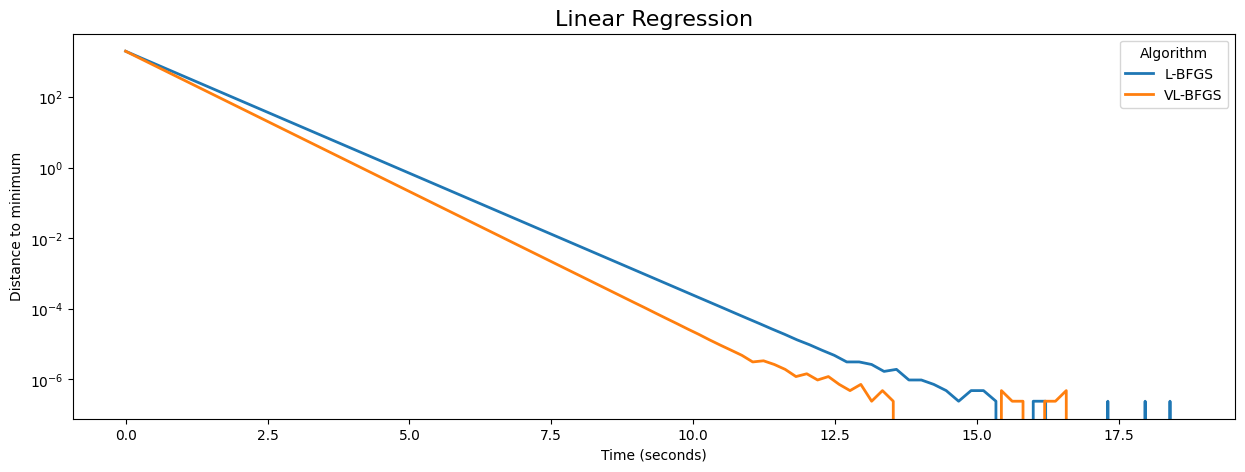

In [19]:
f_min = min(f_min_lbfgs[-1], f_min_vlbfgs[-1])

plt.figure(figsize=(15, 5))
plt.semilogy(np.linspace(0, time_lbfgs, len(f_min_lbfgs)), np.array(f_min_lbfgs) - f_min, lw=2, label='L-BFGS')
plt.semilogy(np.linspace(0, time_vlbfgs, len(f_min_vlbfgs)), np.array(f_min_vlbfgs) - f_min, lw=2, label='VL-BFGS')
plt.yscale('log')
plt.title("Linear Regression", fontsize=16)
plt.legend(title='Algorithm', loc='best')
plt.xlabel('Time (seconds)')
plt.ylabel('Distance to minimum')
plt.show()

### Increase of features

In [4]:
import utils_torch
import lbfgs_torch
import torch
from tqdm import tqdm

In [5]:
f = utils_torch.loss_linreg
f_grad = utils_torch.grad_linreg

In [10]:
d_list = np.arange(0, 50001, 5000)
n = 50000
lbda = 1. / n ** (0.5)

times_lbfgs = []
times_vlbfgs = []

for d in tqdm(d_list[1:]):
    coefs = torch.randn(d)
    _A, _b = utils_torch.simulate_data(coefs, n)

    x_init = torch.zeros_like(coefs)

    lbfgs_optimizer = lbfgs_torch.LBFGS(f, f_grad, m=10, vector_free=False, max_iter=100, device='cuda:0')
    _, _, time  = lbfgs_optimizer.fit(x_init, _A, _b, lbda)
    times_lbfgs.append(time)

    vlbfgs_optimizer = lbfgs_torch.LBFGS(f, f_grad, m=10, vector_free=True, max_iter=100, device="cuda:0")
    _, _, time = vlbfgs_optimizer.fit(x_init, _A, _b, lbda)
    times_vlbfgs.append(time)

    del _A
    del _b
    del x_init
    del coefs


100%|██████████| 10/10 [06:00<00:00, 36.01s/it]


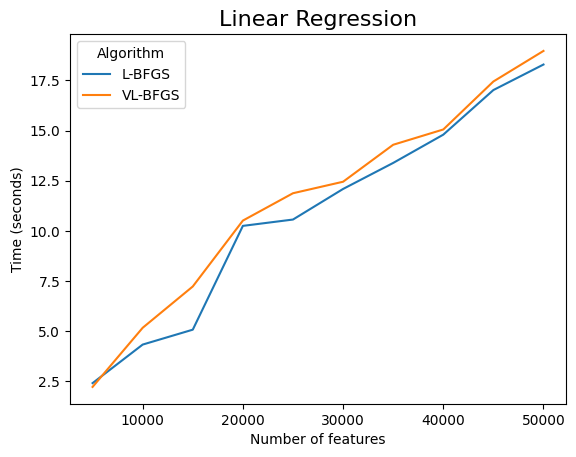

In [13]:
plt.plot(d_list[1:], times_lbfgs, label="L-BFGS")
plt.plot(d_list[1:], times_vlbfgs, label="VL-BFGS")
plt.title("Linear Regression", fontsize=16)
plt.legend(title='Algorithm', loc='best')
plt.xlabel('Number of features')
plt.ylabel('Time (seconds)')
plt.show()

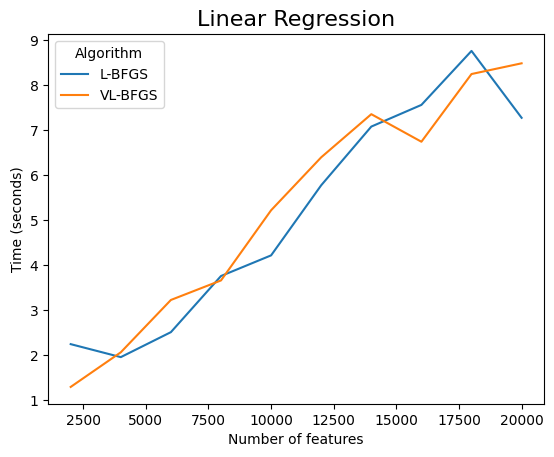

In [9]:
plt.plot(d_list[1:], times_lbfgs, label="L-BFGS")
plt.plot(d_list[1:], times_vlbfgs, label="VL-BFGS")
plt.title("Linear Regression", fontsize=16)
plt.legend(title='Algorithm', loc='best')
plt.xlabel('Number of features')
plt.ylabel('Time (seconds)')
plt.show()

## Optimization on real data

### Get Data

In [1]:
import numpy as np
import torch

We choose to take the Million Song Dataset taken from the UCI dataset website.

In [10]:
print("Loading data...")
with open('YearPredictionMSD.txt', 'r') as f:
    # read contents into NumPy array
    data = np.loadtxt(f, delimiter=',')
y = data[:,0].astype(int)
X = data[:,1:]
del data
print("Data loaded.")

print("Change to tensor...")
X = torch.from_numpy(X)
y = torch.from_numpy(y)
print("Data changed.")

d = X.shape[1]
n = X.shape[0]

print("Number of features: ", d)
print("Number of samples: ", n)

Loading data...
Data loaded.
Change to tensor...
Data changed.
Number of features:  90
Number of samples:  515345


### Optimization

In [8]:
import utils_torch
import lbfgs_torch

In [11]:
lbda = 1. / n ** (0.5)

f = utils_torch.loss_linreg
f_grad = utils_torch.grad_linreg

x_init = torch.rand(d)

In [ ]:
print("\n---- L-BFGS CPU ----")
lbfgs_optimizer = lbfgs_torch.LBFGS(f, f_grad, m=10, vector_free=False, max_iter=100, device='cpu')
x_min_lbfgs_cpu, f_min_lbfgs_cpu, time_lbfgs_cpu  = lbfgs_optimizer.fit(x_init, _A, _b, lbda)
print("Computation time: ", time_lbfgs)

print("\n---- L-BFGS GPU ----")
lbfgs_optimizer = lbfgs_torch.LBFGS(f, f_grad, m=10, vector_free=False, max_iter=100, device='cuda:0')
x_min_lbfgs, f_min_lbfgs, time_lbfgs  = lbfgs_optimizer.fit(x_init, _A, _b, lbda)
print("Computation time: ", time_lbfgs)

print("\n---- VL-BFGS GPU ----")
vlbfgs_optimizer = lbfgs_torch.LBFGS(f, f_grad, m=10, vector_free=True, max_iter=100, device="cuda:0")
x_min_vlbfgs, f_min_vlbfgs, time_vlbfgs = vlbfgs_optimizer.fit(x_init, _A, _b, lbda)
print("Computation time: ", time_vlbfgs)

In [ ]:
f_min = min(f_min_lbfgs_cpu[-1], f_min_lbfgs[-1], f_min_vlbfgs[-1])

plt.figure(figsize=(15, 5))
plt.semilogy(np.linspace(0, time_lbfgs_cpu, len(f_min_lbfgs_cpu)), np.array(f_min_lbfgs_cpu) - f_min, lw=2, label='L-BFGS CPU')
plt.semilogy(np.linspace(0, time_lbfgs, len(f_min_lbfgs)), np.array(f_min_lbfgs) - f_min, lw=2, label='L-BFGS GPU')
plt.semilogy(np.linspace(0, time_vlbfgs, len(f_min_vlbfgs)), np.array(f_min_vlbfgs) - f_min, lw=2, label='VL-BFGS GPU')
plt.yscale('log')
plt.title("Linear Regression", fontsize=16)
plt.legend(title='Algorithm', loc='best')
plt.xlabel('Time (seconds)')
plt.ylabel('Distance to minimum')
plt.show()